In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
from wordcloud import WordCloud

#Load the data
consumer_complaints=pd.read_csv('Consumer_Complaints.csv')

#Select relevant columns
df1=consumer_complaints.dropna(subset=["Consumer complaint narrative"])\
[["Product","Consumer complaint narrative", "Company response to consumer", "Complaint ID"]]

#Select three types of company responses
df1=df1[(df1["Company response to consumer"] == "Closed with explanation")|
        (df1["Company response to consumer"] == "Closed with monetary relief")|\
        (df1["Company response to consumer"] == "Closed with non-monetary relief")]\
[["Product","Consumer complaint narrative", "Company response to consumer", "Complaint ID"]]

print (df1[0:10])
print ('\n')
print ("Number of complaints with actual narratives: "+str(len(df1.index)))

[nltk_data] Downloading package words to /home/wenbo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/wenbo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              Product  \
1                                        Student loan   
2                         Credit card or prepaid card   
7                                            Mortgage   
13                                           Mortgage   
14                                   Credit reporting   
16  Credit reporting, credit repair services, or o...   
25  Credit reporting, credit repair services, or o...   
27  Credit reporting, credit repair services, or o...   
41                                    Debt collection   
52                                    Debt collection   

                         Consumer complaint narrative  \
1   When my loan was switched over to Navient i wa...   
2   I tried to sign up for a spending monitoring p...   
7   My mortgage is with BB & T Bank, recently I ha...   
13  The entire lending experience with Citizens Ba...   
14  My credit score has gone down XXXX points in t...   
16  I few months back I contac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe91d80b240>,
      dtype=object)

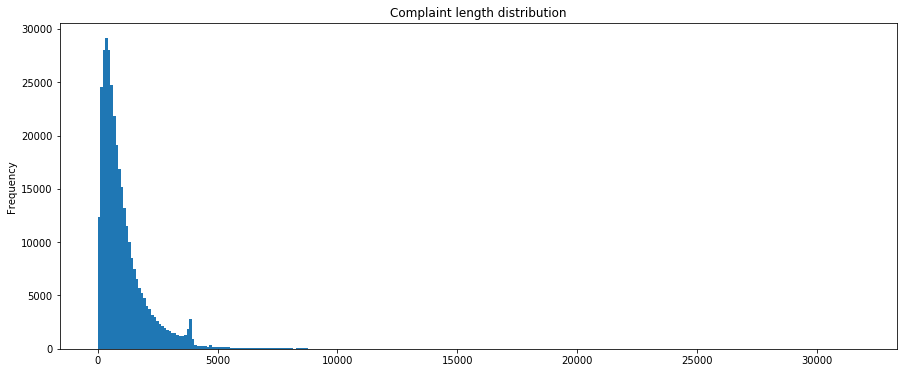

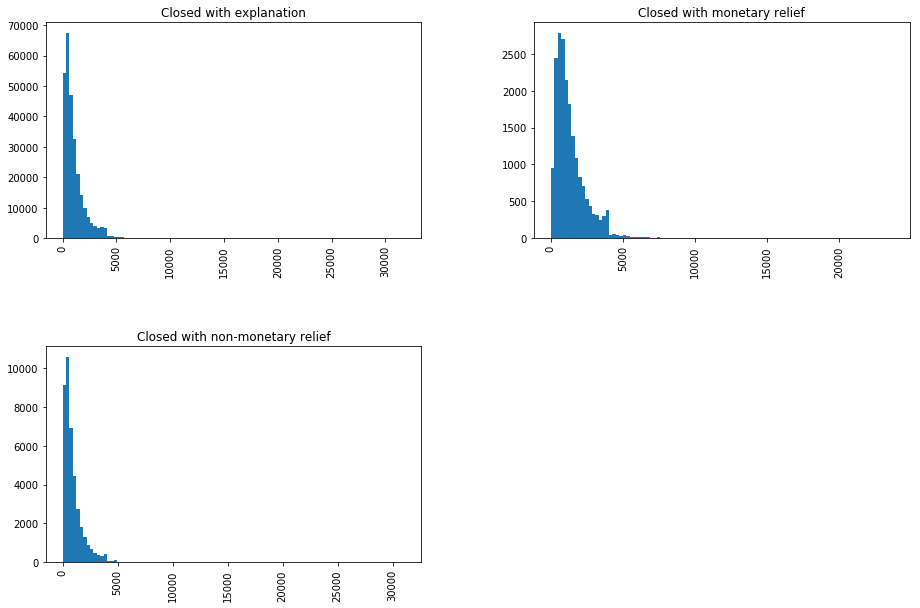

In [2]:
df1["length"]=df1["Consumer complaint narrative"].apply(len)
df1["length"].plot.hist(bins=300, figsize=(15,6), title="Complaint length distribution")
df1.hist(column="length", by="Company response to consumer", bins=100, figsize=(15,10))

The distributions of the length (in number of characters) of complaint narratives are centered around 1000, for various closing types.

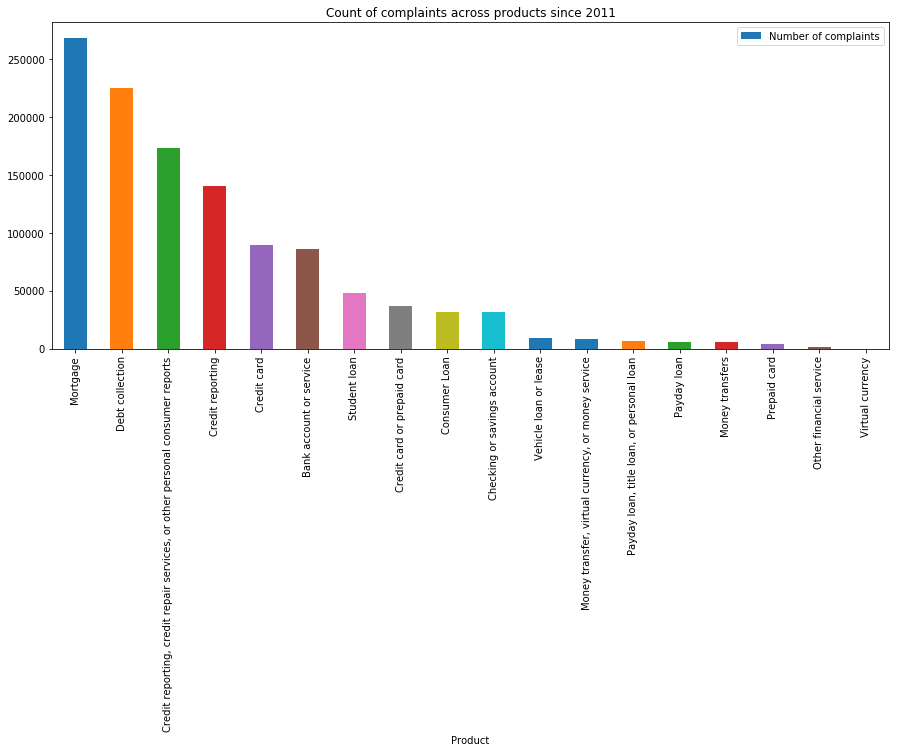

In [3]:
df2=consumer_complaints.groupby(['Product'])['Complaint ID'].count().reset_index(name='Number of complaints')
df2.sort_values(by=["Number of complaints"], inplace=True, ascending=False)
df2.plot(x='Product', y='Number of complaints', kind='bar', figsize=(15,6),\
         title='Count of complaints across products since 2011')

Mortgages received the most number of complaints.

In [4]:
zipcode=pd.read_csv('zip_code_database.csv', encoding = "ISO-8859-1")
zipcode.rename(columns={'zip':'ZIP code'}, inplace=True)
zipcode['ZIP code'] = zipcode['ZIP code'].astype(str)

consumer_complaints_with_geo=pd.merge(consumer_complaints, zipcode, on='ZIP code', how='left')
df3=consumer_complaints_with_geo[(consumer_complaints_with_geo['Product']=='Mortgage')]

plt.figure(figsize=(30,25))

import numpy as np
from mpl_toolkits.basemap import Basemap

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='white')

x,y = m(df3['longitude'].values, df3['latitude'].values)                         
m.plot(x,y,'bo',markersize=1)
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

<Figure size 2160x1800 with 0 Axes>

As shown above, the complaints on mortgages mostly came from urban areas. 

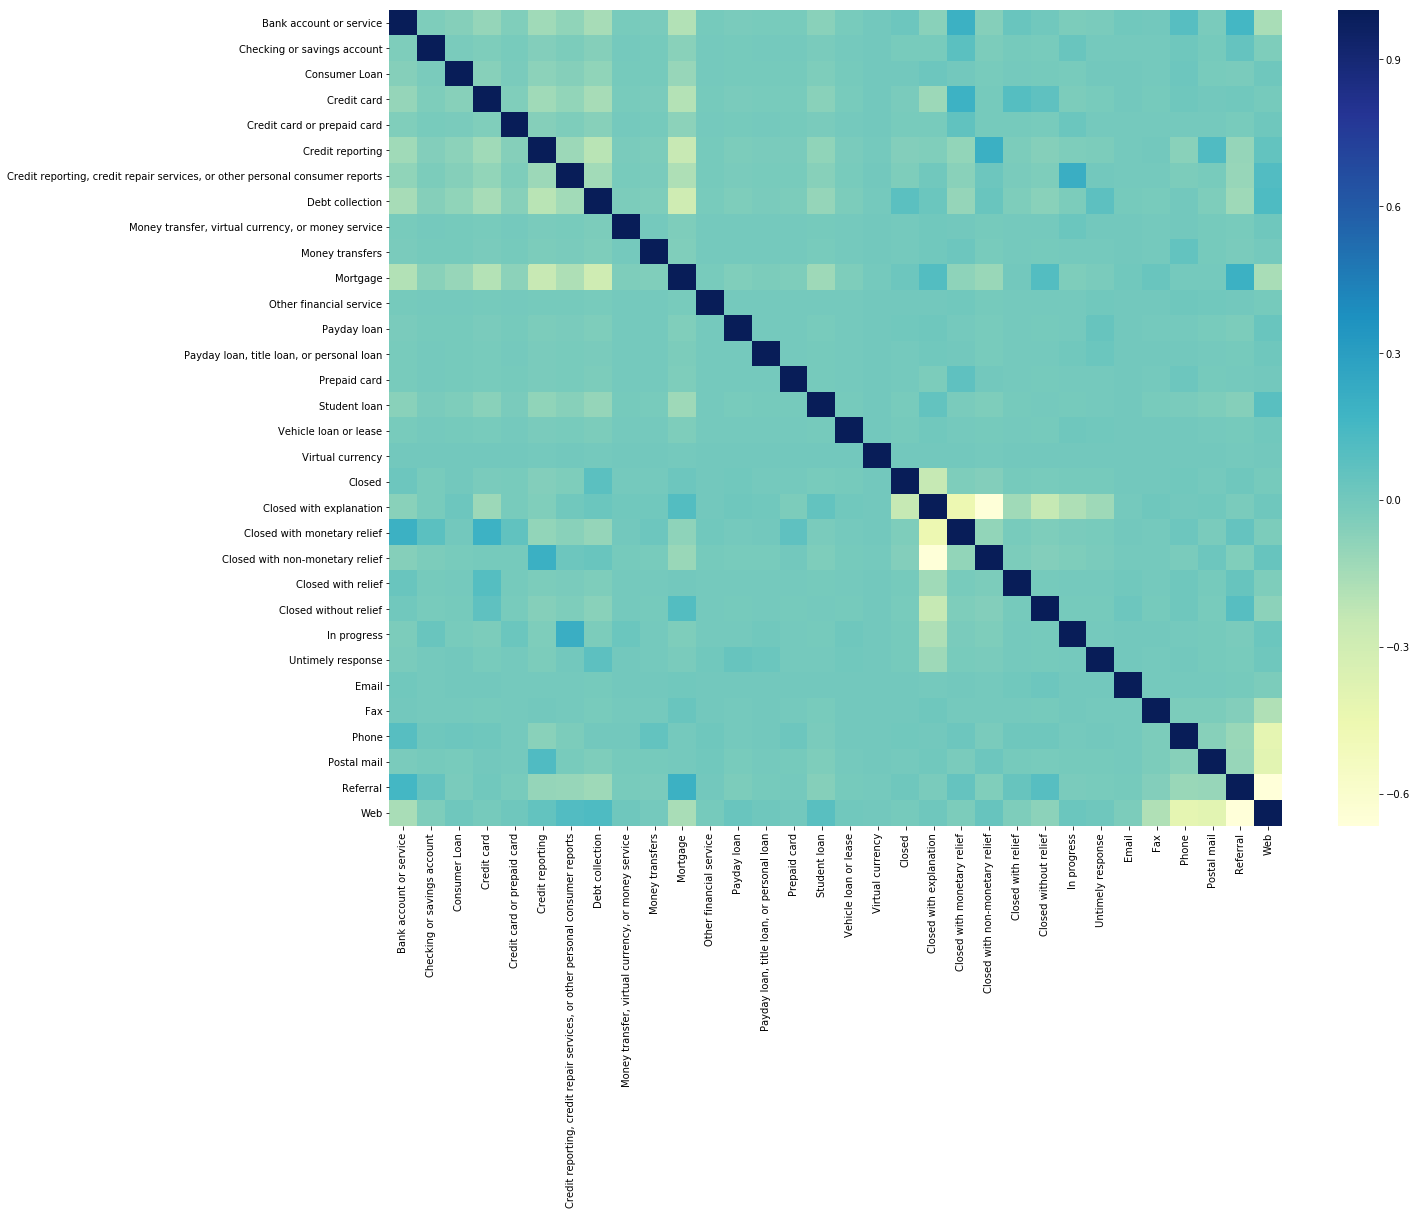

In [5]:
product=pd.get_dummies(consumer_complaints['Product'])
company_response=pd.get_dummies(consumer_complaints['Company response to consumer'])
submit_method=pd.get_dummies(consumer_complaints['Submitted via'])

result=pd.concat([product, company_response, submit_method], axis=1)
corr = result.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values, cmap="YlGnBu")
plt.show()

The heat map/correlations show the following:

1) Mortgage related complaints are generally submitted via referral, and they tend to be closed without relief, or to be closed with explanations;

2) Credit card and bank account services related complaints are more likely to be closed with monetary relief

In [17]:
def clean_up_text(text):
    list_of_words = []
    for word in nltk.wordpunct_tokenize(text):
        if word.lower() in words:
            list_of_words.append(word)
    return " ".join(list_of_words)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40, 
        scale=3).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

c:\users\wenbo yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


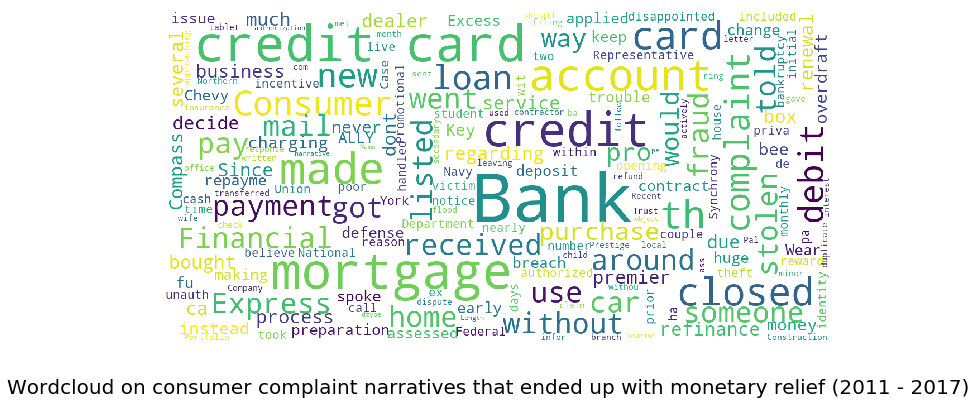

In [21]:
df3 = df1.loc[df1["Company response to consumer"] == "Closed with monetary relief"]
df3["Consumer complaint narrative"] = df3["Consumer complaint narrative"].apply(lambda x: clean_up_text(x))
show_wordcloud(df3["Consumer complaint narrative"], "Wordcloud on consumer complaint narratives \
that ended up with monetary relief (2011 - 2017)")